# Starter example for pyicon

Some specific commands for Jupyter:

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic

## Names and paths

Define the name of the simulation, its grid, the path to the data and paths to the grid:

In [3]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
string = 'asdf{}'.format(run)
string2 = 'asdf'+run+'asdf'
string3 = 'asdf%sasdf' % (run)
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

## Pyicon IconData object

Create a pyicon IconData object. This object contains information about the grid, and the time steps which are in the given data directory.

In [4]:
IcD = pyic.IconData(
               fname        = run+'_????????????????.nc',
               path_data    = path_data,
               path_grid    = path_grid,
               gname        = gname,
               lev          = lev,
               #path_ckdtree = path_ckdtree,
               #section_name = '',
               #fpath_fx     = fpath_fx,
               do_triangulation = True,
               omit_last_file   = False
              )

## Load the data

Specify some indices (it for time and iz for depth) that should be used to load a subset of the data (one level at one time step):

In [5]:
# --- specify time step
it = np.argmin(np.abs(IcD.times-np.datetime64('2295-01-01T00:00:00')))
# --- specify depth level
iz = np.argmin(np.abs(IcD.depthc-100.))

Finally load the data (in this case temperature):

In [6]:
f = Dataset(IcD.flist_ts[it], 'r')
to = f.variables['to'][IcD.its[it],iz,:]
to_3d = f.variables['to'][IcD.its[it],:,:]
f.close()

Mask land values (assuming 0 data values to be land):

In [7]:
to[to==0.0] = np.ma.masked

We can calculate the mean value:

In [8]:
to.mean()

14.134106462480295

or get information about the size of the data:

In [9]:
to.shape

(235403,)

In [10]:
to_3d.shape

(64, 235403)

## Plotting on the original triangular grid

First mask land values (simply assuming that 0 data values are land):

In [11]:
mask_land = to.mask
# The mask needs to be applied to IconData triangulation object. 
# It is important to add the mask to the IcD.mask_bt mask which masks longitudinally periodic triangles.
IcD.Tri.set_mask(IcD.mask_bt+mask_land)

Text(0.5, 1.0, '$^o$C')

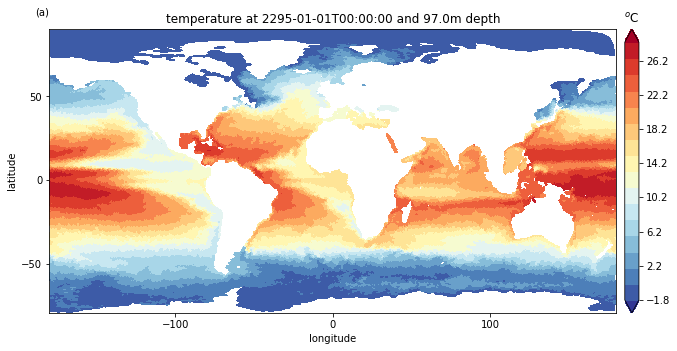

In [12]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(IcD.Tri, to, ax=ax, cax=cax, clim='auto', cincr=2)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('temperature at %s and %.1fm depth'%(IcD.times[it], IcD.depthc[iz]))
cax.set_title('$^o$C')

## Interpolate data to a regular grid

Use the pyicon interp_to_rectgrid function. The path to the regular grid ckdtree file (fpath_ckdtree) needs to be specified. It decides which regular grid is taken but only those grids can be chosen which were calculated and saved externally.

In [16]:
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
lon, lat, toi = pyic.interp_to_rectgrid(to, fpath_ckdtree, coordinates='clat clon')

Text(0.5, 1.0, '$^o$C')

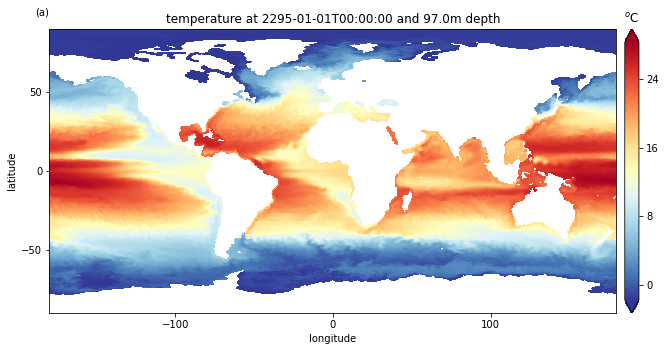

In [17]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5)
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, toi, ax=ax, cax=cax, clim='auto')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('temperature at %s and %.1fm depth'%(IcD.times[it], IcD.depthc[iz]))
cax.set_title('$^o$C')

## Interpolate data to a section

Use the pyicon interp_to_section function. The path to the section ckdtree file (fpath_ckdtree_sec) needs to be specified. It decides which section file is taken but only those sections can be chosen which were calculated and saved externally.

In [16]:
fpath_ckdtree_sec = f'{path_grid}ckdtree/sections/{gname}_nps300_30W80S_30W80N.npz'
lon_sec, lat_sec, dist_sec, to_sec = pyic.interp_to_section(to_3d, fpath_ckdtree_sec, coordinates='clat clon')

(5500.0, 0.0)

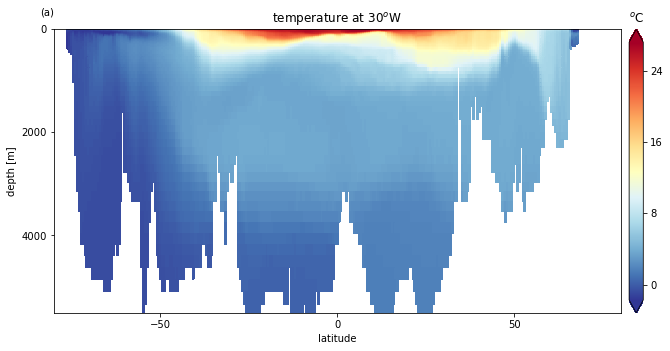

In [17]:
hca, hcb = pyic.arrange_axes(1,1, plot_cb=True, asp=0.5, fig_size_fac=2.5,
                             xlabel='latitude', ylabel='depth [m]')
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lat_sec, IcD.depthc, to_sec, ax=ax, cax=cax, clim='auto')
ax.set_title('temperature at 30$^o$W')
cax.set_title('$^o$C')
ax.set_ylim(5500,0)